# Deliverable #2

The second deliverable that will also, once again, serve as a practical activity. This lesson is connected to the 3rd lesson, which is about Deep Convoluted Neural Network (DCNN).

**Instructions**

Download the [CIFAR-10](https://paperswithcode.com/dataset/cifar-10) dataset from any dataset repository. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Then train a convolutional neural network model. Also, explore and tweak the model by using Regularization techniques. Show the performance of the model using model history line plot and the classification evaluation using confusion matrix.

Write a report containing the Classification Result. Submit the report file named as D2_LastName.pdf and a zip file named as D2_LastName.zip containing your code.

## Imports

All needed libraries will be imported here.

Unless conditional, all imports must be done in this section to prevent workspace cluttering. Imports are sorted in an ascending manner, starting from "a" to "Z".

In [1]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model, to_categorical
import datetime
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
import tensorflow as tf

%matplotlib inline

c:\Users\Virus5600\miniconda3\envs\deep-learning\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Data and Variable

Sets all the global data and variables here.

Global variables will be defined and instantiated in this section, preventing a confusing clutter down the line and allowing readability when revisions are needed.

### Instantiations

Instantiations of variables will be done here, preventing mixture of variable preview and definition.

#### Variables

In [2]:

try:
    if os is None or EarlyStopping is None or ReduceLROnPlateau is None:
        raise ImportError("os, EarlyStopping, or ReduceLROnPlateau module not found")
except NameError:
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    import os

data = {
    "train": {
        "raw": [os.path.join('data', file) for file in os.listdir("data") if file.startswith('data_batch_')],
        "loaded": {},
        "processed": None
    },
    "test": {
        "raw": os.path.join('data', 'test_batch'),
        "loaded": {},
        "processed": None
    },
    "meta": os.path.join('data', 'batches.meta')
}
"""
A dictionary to hold the data for the CIFAR-10 dataset.
The dictionary contains the following keys:

- train: A dictionary containing the training data. It has two keys:
    - raw: A list of file paths for the training data files.
    - loaded: A dictionary to hold the loaded training data.
    - processed: A dictionary to hold the processed training data.
- test: A dictionary containing the test data. It has two keys:
    - raw: The file path for the test data file.
    - loaded: A dictionary to hold the loaded test data.
    - processed: A dictionary to hold the processed test data.
- meta: The file path for the metadata file.

:var data: dict
"""

callbacks = [
    EarlyStopping(
        monitor = 'val_loss',
        patience = 10,
        verbose = 2,
        restore_best_weights = True
    ),
    # ReduceLROnPlateau(
    #     monitor = 'val_loss',
    #     factor = 0.5,
    #     patience = 5,
    #     verbose = 2,
    #     min_lr = 1e-6
    # )
]
"""
A list of callbacks for the model training. Currently, it contains
the following callbacks:
- EarlyStopping: Stops training when a monitored metric has stopped improving.
"""

None

#### Functions

In [3]:
def unpickle(file):
    """
    Decompiles a pickle file.

    :param file: Path to the pickle file.
    :type file: str
    
    :return: The unpickled data.
    :rtype: dict
    """
    global pickle
    try:
        pickle
    except NameError:
        import pickle

    if not os.path.isfile(file):
        raise FileNotFoundError(f"File {file} not found.")
    
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

def unpickleToTuple(file):
    """
    Decompiles a pickle file into a tuple. The tuple
    contains the `data` and `labels` keys from the unpickled data
    in that respective order.

    The `data` key contains the image data and the `labels` key
    contains the labels for the images.

    The `data` key is a numpy array of shape (n, 3072) where n is the
    number of images. The `labels` key is a list of length n containing
    the labels for the images.

    :param file: Path to the pickle file.
    :type file: str
    
    :return: The unpickled data as a tuple.
    :rtype: tuple
    """
    data = unpickle(file)
    return (data[b'data'], data[b'labels'])

def showImg(input, title = None, axis = False):
    """
    Displays an image.

    :param input: The image to display.
    :type input: numpy.ndarray
    
    :param title: Title of the image.
    :type title: str

    :param axis: Whether to show the axis or not.
    :type axis: bool
    """
    global plt
    if plt is None:
        import matplotlib.pyplot as plt
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    if not axis:
        plt.axis('off')
    plt.show()

None

### Previews

In [4]:
print(f"Training data files: {data['train']['raw']}")
print(f"Testing data file: {data['test']['raw']}")
print(f"Meta data file: {data['meta']}")

Training data files: ['data\\data_batch_1', 'data\\data_batch_2', 'data\\data_batch_3', 'data\\data_batch_4', 'data\\data_batch_5']
Testing data file: data\test_batch
Meta data file: data\batches.meta


In [5]:
try:
    random
except NameError:
    import random

for file in data['train']["raw"]:
    print(f"Unpickling {file}...")
    batch = unpickle(file)
    print(f"Unpickled {file} with keys: {batch.keys()}")
    print(f"Batch shape: {batch[b'data'].shape}")
    print(f"Labels shape: {len(batch[b'labels'])}")
    print(f"Batch size: {len(batch[b'data'])}")
    print(f"Batch content size: {len(batch[b'data'][random.randint(0, len(batch[b'data']) - 1)])}")
    print(f"Peek in the batch: {batch[b'data']}")
    print(f"Peek in the batch content: {batch[b'data'][random.randint(0, len(batch[b'data']) - 1)]}")
    print("==============================================")
    data['train']["loaded"][file] = batch

Unpickling data\data_batch_1...
Unpickled data\data_batch_1 with keys: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Batch shape: (10000, 3072)
Labels shape: 10000
Batch size: 10000
Batch content size: 3072
Peek in the batch: [[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]]
Peek in the batch content: [122 125 177 ...   8  19  34]
Unpickling data\data_batch_2...
Unpickled data\data_batch_2 with keys: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Batch shape: (10000, 3072)
Labels shape: 10000
Batch size: 10000
Batch content size: 3072
Peek in the batch: [[ 35  27  25 ... 169 168 168]
 [ 20  20  18 ... 111  97  51]
 [116 115 155 ...  18  84 124]
 ...
 [127 139 155 ... 197 192 191]
 [190 200 208 ... 163 182 192]
 [177 174 182 ... 119 127 136]]
Peek in the batch content: [61 60 60 ... 22 19 20]
Unpickling data\data_bat

In [6]:
try:
    random
except NameError:
    import random

print(f"Unpickling {data['test']['raw']}...")
batch = unpickle(data['test']['raw'])
print(f"Unpickled {data['test']['raw']} with keys: {batch.keys()}")
print(f"Batch shape: {batch[b'data'].shape}")
print(f"Labels shape: {len(batch[b'labels'])}")
print(f"Batch size: {len(batch[b'data'])}")
print(f"Batch content size: {len(batch[b'data'][random.randint(0, len(batch[b'data']) - 1)])}")
print(f"Peek in the batch: {batch[b'data']}")
print(f"Peek in the batch content: {batch[b'data'][random.randint(0, len(batch[b'data']) - 1)]}")
print("==============================================")
data['test']["loaded"] = batch

Unpickling data\test_batch...
Unpickled data\test_batch with keys: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Batch shape: (10000, 3072)
Labels shape: 10000
Batch size: 10000
Batch content size: 3072
Peek in the batch: [[158 159 165 ... 124 129 110]
 [235 231 232 ... 178 191 199]
 [158 158 139 ...   8   3   7]
 ...
 [ 20  19  15 ...  50  53  47]
 [ 25  15  23 ...  80  81  80]
 [ 73  98  99 ...  94  58  26]]
Peek in the batch content: [137 133 129 ...  97  94  90]


In [7]:
data['meta'] = unpickle(data['meta'])
data['meta']

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [8]:
data['train']['loaded'][f'data\\data_batch_{random.randint(1, 5)}']

{b'batch_label': b'training batch 1 of 5',
 b'labels': [6,
  9,
  9,
  4,
  1,
  1,
  2,
  7,
  8,
  3,
  4,
  7,
  7,
  2,
  9,
  9,
  9,
  3,
  2,
  6,
  4,
  3,
  6,
  6,
  2,
  6,
  3,
  5,
  4,
  0,
  0,
  9,
  1,
  3,
  4,
  0,
  3,
  7,
  3,
  3,
  5,
  2,
  2,
  7,
  1,
  1,
  1,
  2,
  2,
  0,
  9,
  5,
  7,
  9,
  2,
  2,
  5,
  2,
  4,
  3,
  1,
  1,
  8,
  2,
  1,
  1,
  4,
  9,
  7,
  8,
  5,
  9,
  6,
  7,
  3,
  1,
  9,
  0,
  3,
  1,
  3,
  5,
  4,
  5,
  7,
  7,
  4,
  7,
  9,
  4,
  2,
  3,
  8,
  0,
  1,
  6,
  1,
  1,
  4,
  1,
  8,
  3,
  9,
  6,
  6,
  1,
  8,
  5,
  2,
  9,
  9,
  8,
  1,
  7,
  7,
  0,
  0,
  6,
  9,
  1,
  2,
  2,
  9,
  2,
  6,
  6,
  1,
  9,
  5,
  0,
  4,
  7,
  6,
  7,
  1,
  8,
  1,
  1,
  2,
  8,
  1,
  3,
  3,
  6,
  2,
  4,
  9,
  9,
  5,
  4,
  3,
  6,
  7,
  4,
  6,
  8,
  5,
  5,
  4,
  3,
  1,
  8,
  4,
  7,
  6,
  0,
  9,
  5,
  1,
  3,
  8,
  2,
  7,
  5,
  3,
  4,
  1,
  5,
  7,
  0,
  4,
  7,
  5,
  5,
  1,
  0,
  9,
  6,
  9,
 

In [9]:
data['meta'][b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

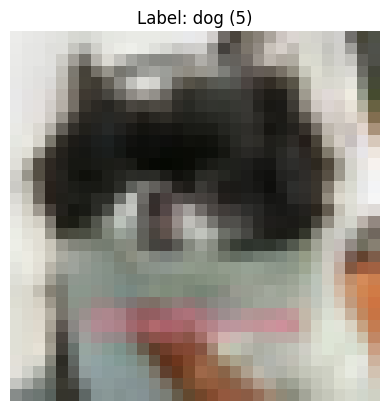

In [10]:
try:
    random
except NameError:
    import random

target = data['train']['loaded'][f'data\\data_batch_{random.randint(1, 5)}']
targetIndex = random.randint(0, len(target[b'data']) - 1)
label = target[b'labels'][targetIndex]
label = f"{data['meta'][b'label_names'][label].decode('UTF-8')} ({label})"

showImg(
    target[b'data'][targetIndex].reshape(3, 32, 32).transpose(1, 2, 0),
    f"Label: {label}",
)

In [11]:
data['test']['loaded'][b'data']

array([[158, 159, 165, ..., 124, 129, 110],
       [235, 231, 232, ..., 178, 191, 199],
       [158, 158, 139, ...,   8,   3,   7],
       ...,
       [ 20,  19,  15, ...,  50,  53,  47],
       [ 25,  15,  23, ...,  80,  81,  80],
       [ 73,  98,  99, ...,  94,  58,  26]], dtype=uint8)

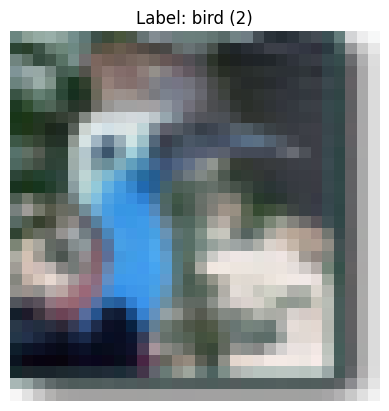

In [12]:
try:
    random
except NameError:
    import random

target = data['test']['loaded']
targetIndex = random.randint(0, len(target[b'data']) - 1)
label = target[b'labels'][targetIndex]
label = f"{data['meta'][b'label_names'][label].decode('UTF-8')} ({label})"

showImg(
    data['test']['loaded'][b'data'][targetIndex].reshape(3, 32, 32).transpose(1, 2, 0),
    f"Label: {label}"
)

## Process

Here begins the process which includes data splitting and pre-processing.

### Splitting the Data

In [13]:
# Not applicable for this dataset...

### Pre Processing

In [14]:
try:
    if ImageDataGenerator is None or random is None or train_test_split is None:
        raise NameError("ImageDataGenerator or random is not defined.")
except NameError:
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from sklearn.model_selection import train_test_split
    import random

data['train']['processed'] = {
    'combined': {
        'data': None,
        'labels': None,
        'generator': None
    },
    'validation': {
        'data': None,
        'labels': None,
        'generator': None
    },
}

data['test']['processed'] = {
    'generator': None,
}

# Splitting the data into training and validation sets
x = []
y = []
for file in data['train']['loaded']:
    x.append(data['train']['loaded'][file][b'data'])
    y.append(data['train']['loaded'][file][b'labels'])
x_train, x_val, y_train, y_val = train_test_split(
    np.concatenate(x),
    np.concatenate(y),
    test_size = 0.2
)

#######################
### VALIDATION DATA ###
#######################
data['train']['processed']['validation']['data'] = x_val
data['train']['processed']['validation']['labels'] = y_val
data['train']['processed']['validation']['generator'] = (ImageDataGenerator(
    rescale = 1./255,
)).flow(
    data['train']['processed']['validation']['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
    data['train']['processed']['validation']['labels'],
)

##################
### TRAIN DATA ###
##################
data['train']['processed']['combined']['data'] = x_train
data['train']['processed']['combined']['labels'] = y_train
data['train']['processed']['combined']['generator'] = (ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)).flow(
    data['train']['processed']['combined']['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
    data['train']['processed']['combined']['labels'],
)


#################
### TEST DATA ###
#################
data['test']['processed']['generator'] = (ImageDataGenerator(
    rescale = 1./255,
)).flow(
    data['test']['loaded'][b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
    data['test']['loaded'][b'labels'],
)

### Creating the Model

#### Neural Network

In [15]:
try:
    Sequential
except NameError:
    from tensorflow.keras.models import Sequential

model = Sequential()

#### Layers

In [16]:
try:
    if Dense is None or Conv2D is None or MaxPooling2D is None or Dropout is None or Flatten is None or ReLU is None or BatchNormalization is None:
        raise ImportError("Required modules not imported.")
except NameError or ImportError:
    from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, ReLU

# Input Layers
inputLayers = [
    # Start with 4 filters, 3x3 kernel, ReLU activation. Started with only 4
    # since the image is only 32x32. This allows the model to get low-level
    # features from the image.
    Conv2D(16, (3, 3), activation = 'relu', padding = 'same', input_shape = (32, 32, 3)),
    # BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Middle with 8 filters, 3x3 kernel, ReLU activation
    # This allows the model to get mid-level features from the image.
    Conv2D(32, (3, 3), activation = 'relu', padding = 'same'),
    # BatchNormalization(),
    MaxPooling2D((2, 2)),

    # End with 32 filters, 3x3 kernel, ReLU activation
    # This allows the model to get high-level features from the image.
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    # BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Test if adding a new layer helps the model learn better.
    # Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    # BatchNormalization(),
    # MaxPooling2D((2, 2)),
]

# Middle Layers (Including Hidden Layers)
middleLayers = [
    # Flatten the input to a 1D vector
    Flatten(),

    # Fully connected layer with 512 neurons and ReLU activation
    # This allows the model to learn complex features from the image.
    Dense(512, activation = 'relu'),

    # Dropout layer with >= 0.5 dropout rate
    # Note: If this layer is uncommented, that means the model underfitted.
    # Dropout(0.5),

    # Dropout layer with < 0.5 dropout rate
    # Note: If this layer is uncommented, that means the model overfitted.
    # Dropout(0.4),
]

# Fully connected layer with 10 neurons (one for each class)
# Uses SoftMax since this is a multi-class classification problem
outputLayer = Dense(10, activation = 'softmax')

print(f"Input Layers: {len(inputLayers)}")
print(f"Middle Layers: {len(middleLayers)}")
print(f"Output Layers: {len([outputLayer])}")
print(f"All Layers: {len([*inputLayers, *middleLayers, outputLayer])}")

Input Layers: 6
Middle Layers: 2
Output Layers: 1
All Layers: 9


#### Summary

In [17]:
for layer in [*inputLayers, *middleLayers, outputLayer]:
    model.add(layer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

#### Compilation and Training

In [18]:
try:
    optimizers
except NameError:
    from tensorflow.keras import optimizers

model.compile(
    optimizer = optimizers.Adam(learning_rate = 1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'],
    run_eagerly = True
)

In [19]:
# Steps per Epoch
SPE = 250
# SPE = len(data['train']['processed']['combined']['data']) // data['train']['processed']['combined']['generator'].batch_size
# Validation Steps
VS = 100
# VS = len(data['train']['processed']['validation']['data']) // data['train']['processed']['validation']['generator'].batch_size

print(f"Length: {len(data['train']['processed']['combined']['data'])} | Batch Size: {data['train']['processed']['combined']['generator'].batch_size}")
print(f"Steps per Epoch to Validation Steps: {SPE} - {VS}")

history = model.fit(
    data['train']['processed']['combined']['generator'],
    steps_per_epoch = SPE,
    epochs = 100,
    validation_data = data['train']['processed']['validation']['generator'],
    validation_steps = VS,
    verbose = 2,
    callbacks = callbacks,
)

Length: 40000 | Batch Size: 32
Steps per Epoch to Validation Steps: 250 - 100
Epoch 1/100
250/250 - 27s - loss: 2.2217 - accuracy: 0.1704 - val_loss: 1.9998 - val_accuracy: 0.3084 - 27s/epoch - 108ms/step
Epoch 2/100
250/250 - 18s - loss: 1.9498 - accuracy: 0.3031 - val_loss: 1.8068 - val_accuracy: 0.3634 - 18s/epoch - 73ms/step
Epoch 3/100
250/250 - 19s - loss: 1.8630 - accuracy: 0.3257 - val_loss: 1.8083 - val_accuracy: 0.3587 - 19s/epoch - 77ms/step
Epoch 4/100
250/250 - 19s - loss: 1.8146 - accuracy: 0.3501 - val_loss: 1.6790 - val_accuracy: 0.4150 - 19s/epoch - 75ms/step
Epoch 5/100
250/250 - 19s - loss: 1.7790 - accuracy: 0.3576 - val_loss: 1.6624 - val_accuracy: 0.4091 - 19s/epoch - 77ms/step
Epoch 6/100
250/250 - 19s - loss: 1.7618 - accuracy: 0.3692 - val_loss: 1.6974 - val_accuracy: 0.3941 - 19s/epoch - 76ms/step
Epoch 7/100
250/250 - 18s - loss: 1.7329 - accuracy: 0.3756 - val_loss: 1.6595 - val_accuracy: 0.4050 - 18s/epoch - 72ms/step
Epoch 8/100
250/250 - 25s - loss: 1.722

## Prediction

Test the model's prediction

In [20]:
from copy import copy
try:
    np
except NameError:
    import numpy as np

generator = copy(data['test']['processed']['generator'])
min = 0
max = 0
avg = 0
logPerBatch = False

forCM = {
    'y_true': [],
    'y_pred': [],
}

for i in range(len(generator)):
    images, labels = generator[i]

    classes = model.predict(images, verbose = 0)
    classes = np.argmax(classes, axis = 1)

    forCM['y_true'].extend(labels)
    forCM['y_pred'].extend(classes)

    if logPerBatch:
        print(f"Classes: {classes}")
        print(f"Labels: {labels}")

    # Accuracy
    accuracy = np.sum(classes == labels) / len(labels)
    if accuracy > max:
        max = accuracy
    if accuracy < min or min == 0:
        min = accuracy
    avg += accuracy

    if logPerBatch:
        print(f"Formula: {np.sum(classes == labels)} / {len(labels)}")
        print(f"Accuracy: {accuracy * 100:.2f}%")
        print(f"Of {len(labels)} images, {np.sum(classes == labels)} were correct while {np.sum(classes != labels)} were incorrect.")

avg /= len(generator)

# Accuracy Range
print(f"Accuracy: {avg * 100:.2f}%")
print(f"Accuracy Range: {min * 100:.2f}% - {max * 100:.2f}%")
print(f"Optimizer used is {model.optimizer.get_config()['name']} with a learning rate of {model.optimizer.learning_rate.numpy()}")

Accuracy: 59.08%
Accuracy Range: 31.25% - 87.50%
Optimizer used is Adam with a learning rate of 9.999999747378752e-05


## Model and Metrics Visualization

### Accuracy

313/313 - 10s - loss: 1.1704 - accuracy: 0.5909 - 10s/epoch - 31ms/step
Accuracy: 59.09%
Using `forCM`: 5909 / 10000 = 59.09%


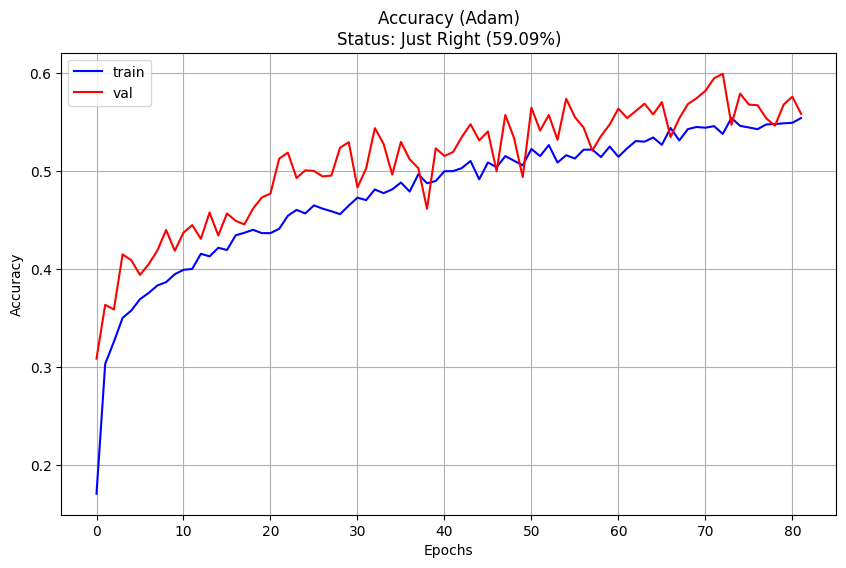

In [21]:
try:
    if datetime is None or sns is None or plt is None or np is None:
        raise ImportError("datetime or sns module not found")
except NameError:
    import datetime
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns

_, accuracy = model.evaluate(
    data['test']['processed']['generator'],
    verbose = 2
)
status = "Underfitted" if accuracy < 0.5 else "Overfitted" if accuracy > 0.9 else "Just Right"
yTrue = np.sum(np.array(forCM['y_true']) == np.array(forCM['y_pred']))
yLength = len(forCM['y_pred'])
yScore = yTrue / yLength

accuracy = accuracy * 100
unixTime = int(datetime.datetime.now().timestamp() * 1e6)

print(f"Accuracy: {accuracy:.2f}%")
print(f"Using `forCM`: {yTrue} / {yLength} = {yScore * 100:.2f}%")

plt.figure(figsize = (10, 6))
plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
plt.legend()
plt.grid()
plt.title(f'Accuracy ({model.optimizer.get_config()["name"]})\nStatus: {status} ({accuracy:.2f}%)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig(f"outputs/accuracy{unixTime} - {accuracy:.2f}%.png")

### Confusion Matrix

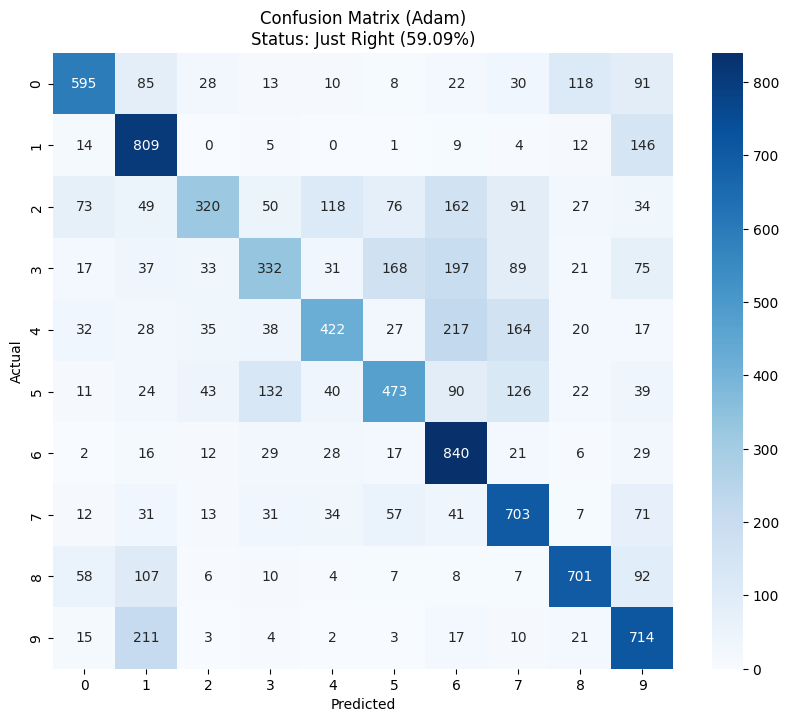

In [22]:
try:
    if confusion_matrix is None or sns is None or plt is None or os is None or datetime is None:
        raise ImportError("Required modules not imported.")
except NameError:
    from sklearn.metrics import confusion_matrix
    import datetime
    import matplotlib.pyplot as plt
    import os
    import seaborn as sns

cm = confusion_matrix(
    forCM['y_true'],
    forCM['y_pred'],
)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')

plt.title(f'Confusion Matrix ({model.optimizer.get_config()["name"]})\nStatus: {status} ({accuracy:.2f}%)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

if not os.path.exists('outputs'):
    os.makedirs('outputs')

plt.savefig(f'outputs/confusion_matrix{unixTime} - {accuracy:.2f}%.png')

### Model Visualization

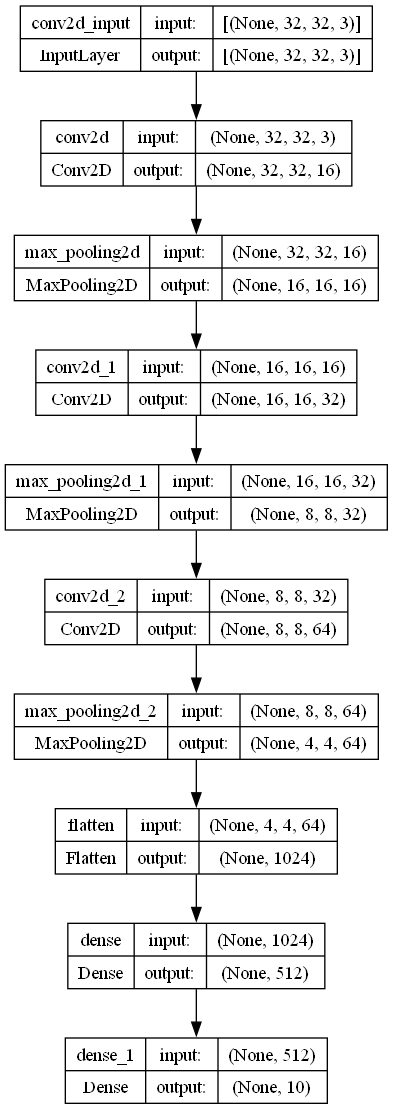

In [23]:
plot_model(model, to_file=f'outputs/model{unixTime} - {accuracy:.2f}%.png', show_shapes=True)